In [ ]:
print("Hello Quantum World of Rigetti")

# Forest

The Rigetti Forest Software Development Kit includes pyQuil, the Rigetti Quil Compiler (quilc), and the Quantum Virtual Machine (qvm).

The install instructions are concise and clear
* https://pyquil.readthedocs.io/en/stable/start.html#
* https://grove-docs.readthedocs.io/en/latest/installation.html#installation

### pyQuil + QVM

In 2 seperate terminals start

quilc -S

qvm -S

before starting the jupyter notebook session

In [ ]:
from pyquil import Program, get_qc
from pyquil.gates import *

# construct a Bell State program
p = Program(H(0), CNOT(0, 1))

# run the program on a QVM
qc = get_qc('9q-square-qvm')
result = qc.run_and_measure(p, trials=10)
print(result[0])
print(result[1])

In [ ]:
# Method 2: instantiate a Program and add an operation to it.
p = Program()
p += X(0)

# run the program on a QVM
qc = get_qc('9q-square-qvm')
result = qc.run_and_measure(p, trials=3) # letting the QuantumComputer abstraction measure all qubits
print(result[0])
print(result[1])

# print pyQuil program to see the equivalent Quil representation
print(p)

Classical memory regions must be explicitly requested and named by a Quil program using the DECLARE directive. 

def declare(self, name, memory_type='BIT', memory_size=1, shared_region=None, offsets=None):
* name is any name you want to give this memory region.
* memory_type is one of 'REAL', 'BIT', 'OCTET', or 'INTEGER' (given as a string). Only BIT and OCTET always have a determined size, which is 1 bit and 8 bits respectively.
* memory_size is the number of elements of that type to reserve.
* shared_region and offsets allow you to alias memory regions. For example, you might want to name the third bit in your readout array as q3_ro. SHARING is currently disallowed for QPUs.

.declare cannot be chained, since it doesn’t return a modified Program object.

In [ ]:
# have to DECLARE a memory space to read measurement “readout results” and abbreviate as ro
p = Program()
roval = p.declare('ro', 'BIT', 2)
p += X(1)
p += MEASURE(0, roval[0])
p += MEASURE(1, roval[1])
print(p)

qc = get_qc('2q-qvm')  # any 'nq-qvm' can be made this way for any reasonable 'n'
executable = qc.compile(p)
result = qc.run(executable)
print(result)

The QPU can only handle MEASURE final programs. You can’t operate gates after measurements.

In [ ]:
p = Program()
roval = p.declare('ro', 'BIT', 1)
p += H(0)
p += MEASURE(0, roval[0])

p.wrap_in_numshots_loop(1000) # Method 2: specifying number of trials

qc = get_qc('1q-qvm') 
executable = qc.compile(p)
result = qc.run(executable)

ones = 0
for i in range(1000):
    if (result[i] == 1):
        ones += 1
print(ones) # expected around 50% of 1000

The Standard Gate Set of Quil and gates.py:
* Pauli gates I, X, Y, Z
* Hadamard gate: H
* Phase gates: PHASE(theta), S, T
* Controlled phase gates: CZ, CPHASE00(alpha), CPHASE01(alpha), CPHASE10(alpha), CPHASE(alpha)
* Cartesian rotation gates: RX(theta), RY(theta), RZ(theta)
* Controlled X gates: CNOT, CCNOT
* Swap gates: SWAP, CSWAP, ISWAP, PSWAP(alpha)

Gate applications in Quil can be preceded by a gate modifier. There are two supported modifiers: DAGGER and CONTROLLED

The parameterized gates take a real or complex floating point number as an argument.

Modern quantum algorithms are often parametric, following a hybrid model. In this hybrid model, the program ansatz (template of gates) is fixed, and iteratively updated with new parameters. These new parameters are often determined by an update given by a classical optimizer. Depending on the complexity of the algorithm, problem of interest, and capabilities of the classical optimizer, this loop may need to run many times. In order to efficiently operate within this hybrid model, parametric compilation can be used.

Parametric compilation allows one to compile the program ansatz just once. Making use of declared memory regions, we can **load values to the parametric gates at execution time, after compilation**. Taking the compiler out of the execution loop for programs like this offers a huge performance improvement compared to compiling the program each time a parameter update is required.

The first step is to build a parametric program, which functions like a template for all the precise programs that will run.

THe example below puts the qubit onto the equator of the Bloch Sphere and then rotates it around the Z axis for some variable angle theta before applying another X pulse and measuring. It is similar to an experiment which measures the qubit frequency.

In [ ]:
import numpy as np

qubit = 0

p = Program()
ro = p.declare("ro", "BIT", 1)
theta_ref = p.declare("theta", "REAL")

p += RX(np.pi / 2, qubit)
p += RZ(theta_ref, qubit)
p += RX(-np.pi / 2, qubit)

p += MEASURE(qubit, ro[0])

qc = get_qc("1q-qvm")
executable = qc.compile(p) # able to compile the program, even with theta still not specified

# Somewhere to store each list of results
parametric_measurements = []

for theta in np.linspace(0, 2 * np.pi, 200):
    # Get the results of the run with the value we want to execute with
    bitstrings = qc.run(executable, {'theta': [theta]})
    # Store our results
    parametric_measurements.append(bitstrings)

New gates can be easily added inline to Quil programs with a matrix representation of the gate. Custom parametric gates require a slightly different way.

In [ ]:
from pyquil.quil import DefGate
from pyquil.parameters import Parameter, quil_sin, quil_cos

# First we define the new gate from a matrix
sqrt_x = np.array([[ 0.5+0.5j,  0.5-0.5j],
                   [ 0.5-0.5j,  0.5+0.5j]])

# Get the Quil definition for the new gate
sqrt_x_definition = DefGate("SQRT-X", sqrt_x)
# Get the gate constructor
SQRT_X = sqrt_x_definition.get_constructor()

# Then we can use the new gate
p = Program()
p += sqrt_x_definition
p += SQRT_X(0)

# A multi-qubit defgate example
x_gate_matrix = np.array(([0.0, 1.0], [1.0, 0.0]))
sqrt_x = np.array([[ 0.5+0.5j,  0.5-0.5j],
                [ 0.5-0.5j,  0.5+0.5j]])
x_sqrt_x = np.kron(x_gate_matrix, sqrt_x)
x_sqrt_x_definition = DefGate("X-SQRT-X", x_sqrt_x)
X_SQRT_X = x_sqrt_x_definition.get_constructor()

# Then we can use the new gate
p += Program(x_sqrt_x_definition, X_SQRT_X(0, 1))

# Define the new gate from a matrix
theta = Parameter('theta')
crx = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, quil_cos(theta / 2), -1j * quil_sin(theta / 2)],
    [0, 0, -1j * quil_sin(theta / 2), quil_cos(theta / 2)]
])

gate_definition = DefGate('CRX', crx, [theta])
CRX = gate_definition.get_constructor()

# Create our program and use the new parametric gate
p += gate_definition
p += CRX(np.pi/2)(0, 1)

# Dynamic definition of custom parametric gate
theta_dyn= p.declare("theta", "REAL")
p += CRX(theta_dyn)(0, 1)

print(p)

p.pop() # If an instruction was appended to a program incorrectly (conditionally)
print(p)

Wavefunction Simulator allows directly inspecting the wavefunction of a quantum state prepared by the program. Because of the probabilistic nature of quantum information, the programs on the QPU can give a distribution of outputs. When running on the QPU or QVM, one can aggregate results (anywhere from tens of trials to 100k+!) that can be sampled to get back a distribution. With the Wavefunction Simulator, the distribution can be examined without having to collect samples from the program. This can save a lot of time for small programs. 

In [ ]:
from pyquil.api import WavefunctionSimulator

print(WavefunctionSimulator().wavefunction(p))

For more info, visit:
* https://pyquil.readthedocs.io/en/stable/basics.html#
* https://pyquil.readthedocs.io/en/stable/apidocs/program.html
* https://pyquil.readthedocs.io/en/stable/apidocs/gates.html

For compiler related settings:
* https://pyquil.readthedocs.io/en/stable/compiler.html#
* https://pyquil.readthedocs.io/en/stable/apidocs/compilers.html
* https://pyquil.readthedocs.io/en/stable/qvm-man.html
* https://pyquil.readthedocs.io/en/stable/quilc-man.html

For QPU related settings:
* https://pyquil.readthedocs.io/en/stable/qvm.html#the-quantum-processing-unit
* https://pyquil.readthedocs.io/en/stable/apidocs/quantum_computer.html
* https://pyquil.readthedocs.io/en/stable/apidocs/devices.html

For noise simulations:
* https://pyquil.readthedocs.io/en/stable/noise.html#
* https://pyquil.readthedocs.io/en/stable/apidocs/noise.html

Classical control flow is not yet supported in the QPU.
* https://pyquil.readthedocs.io/en/stable/advanced_usage.html#classical-control-flow

On QVM, the example below declare a register called flag_register to use as a boolean test for looping, initialized to 1, so while loop will execute. This is often called the loop preamble or loop initialization. The body of the loop is its own Program. This will be a program that applies an X gate followed by a H gate on a qubit. Using the while_do() method to add control flow.

The outer_loop program applied a Quil instruction directly to a classical register. There are several classical commands that can be used in this fashion:
* NOT which flips a classical bit
* AND which operates on two classical bits
* IOR which operates on two classical bits
* MOVE which moves the value of a classical bit at one classical address into another
* EXCHANGE which swaps the value of two classical bits

In [ ]:
# Initialize the Program and declare a 1 bit memory space for our boolean flag
outer_loop = Program()
flag_register = outer_loop.declare('flag_register', 'BIT')

# Set the initial flag value to 1
outer_loop += MOVE(flag_register, 1)

# Define the body of the loop with a new Program
inner_loop = Program()
inner_loop += Program(X(0), H(0))
inner_loop += MEASURE(0, flag_register)

# Run inner_loop in a loop until flag_register is 0
outer_loop.while_do(flag_register, inner_loop)

print(outer_loop)

Conditional branching in the form of the traditional if construct includes constructing programs for each branch of the if, and put it all together by using the if_then() method.

In [ ]:
# Declare our memory spaces
branching_prog = Program()
test_register = branching_prog.declare('test_register', 'BIT')
ro = branching_prog.declare('ro', 'BIT')

# Construct each branch of our if-statement. We can have empty branches
# simply by having empty programs.
then_branch = Program(X(0))
else_branch = Program()

# Construct our program so that the result in test_register is equally likely to be a 0 or 1
branching_prog += H(1)
branching_prog += MEASURE(1, test_register)

# Add the conditional branching
branching_prog.if_then(test_register, then_branch, else_branch)

# Measure qubit 0 into our readout register
branching_prog += MEASURE(0, ro)

print(branching_prog)

qc = get_qc("2q-qvm")
branching_prog.wrap_in_numshots_loop(10)
qc.run(branching_prog)

The Probabilistic Halting Problem: A fun example is to create a program that has an exponentially increasing chance of halting, but that may run forever!

In [ ]:
p = Program()
ro = p.declare('ro', 'BIT', 1)
inside_loop = Program(H(0)).measure(0, ro[0])
p.inst(X(0)).while_do(ro[0], inside_loop)

qc = get_qc('9q-square-qvm')
print (qc.run(qc.compile(p)))

Quantum Algorithms developed on Forest
* https://www.rigetti.com/community
* https://github.com/msohaibalam/Link_to_Quantum_game
* https://github.com/qosf/os_quantum_software

### Grove

A collection of quantum algorithms built using the Rigetti Forest platform.
* Variational-Quantum-Eigensolver (VQE)
* Quantum Approximate Optimization Algorithm (QAOA)
* Quantum Fourier Transform (QFT)
* Phase Estimation Algorithm
* Histogram based Tomography
* Grover’s Search Algorithm and Amplitude Amplification
* Bernstein-Vazirani Algorithm
* Simon’s Algorithm
* Deutsch-Jozsa Algorithm
* Arbitrary State Generation

Links:
* https://grove-docs.readthedocs.io/en/latest/
* https://github.com/rigetti/grove

Quantum Approximate Optimization Algorithm (QAOA) for Max-Cut on a undirected unweighted square-ring

                     models will be ineffective
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -2.049925600216813
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9258329661561333
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9055510767742194
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9162753977320983
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9523211651307175
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9499823964379095
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -2.0101089272813772
	Parameters: [2.55773524 0.28664526 1.62036329 4.06191069] 
	E => -2.239872137660691
	Parameters: [2.55773524 0.28664526 1.62036329 4.06191069] 
	E => -2.088451236810917
	Parameters: [2.51623165 0.27857523 1.77821333 3.73748437] 
	E => -2.6345231341476465
	Parameters: [2.51623165 0.27857523 1.77821333 3.73748437] 
	E => -2.4430524348604856
	Paramete

	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9994084998097734
	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9990086315217765
	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9978018402418547
	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9992228580557323
	Parameters: [1.96750773 0.78235638 1.56240669 3.94097575] 
	E => -3.999411486167628
	Parameters: [1.96637265 0.78410088 1.55210464 3.93517475] 
	E => -3.9995611319901188
	Parameters: [1.96637265 0.78410088 1.55210464 3.93517475] 
	E => -3.999522529950024
	Parameters: [1.96564351 0.78442817 1.57818112 3.91829849] 
	E => -3.9989414034310946
	Parameters: [1.96401775 0.78148373 1.57104348 3.92639008] 
	E => -3.999904767407205
	Parameters: [1.96401775 0.78148373 1.57104348 3.92639008] 
	E => -3.999811022305246
	Parameters: [1.96140985 0.78744607 1.56855377 3.93122177] 
	E => -3.999471774586656
	Parameters: [1.96140985 0.78744607 1.56855377 3.93122177] 

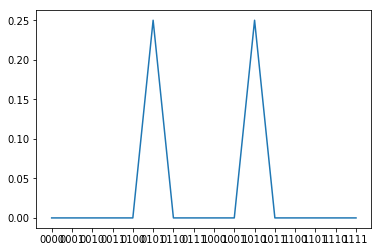

In [14]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
import pyquil.api as api
qvm_connection = api.QVMConnection()

square_ring = [(0,1),(1,2),(2,3),(3,0)]

steps = 2
inst = maxcut_qaoa(graph=square_ring, steps=steps)
betas, gammas = inst.get_angles()

t = np.hstack((betas, gammas))
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = qvm_connection.wavefunction(prog)
wf = wf.amplitudes

for state_index in range(inst.nstates):
    print(inst.states[state_index], np.conj(wf[state_index])*wf[state_index])
    
import matplotlib.pyplot as plt
import cmath 
plt.plot(inst.states, np.conj(wf).real*wf.real)

                     models will be ineffective
	Parameters: [2.8747981  2.75561437 0.11341582 2.98041051 3.03247532 6.40079757
 4.08062243 1.94553844] 
	E => -4.124236979089947
	Parameters: [2.94217618 2.49296988 0.116074   3.05026389 2.97561641 6.23887263
 4.17626201 1.991137  ] 
	E => -4.441118301780691
	Parameters: [2.94217618 2.49296988 0.116074   3.05026389 2.97561641 6.23887263
 4.17626201 1.991137  ] 
	E => -4.266035612596669
	Parameters: [2.6492219  2.64864594 0.11798457 3.100471   2.93474906 6.341564
 4.07285171 2.02391096] 
	E => -4.797697169623133
	Parameters: [2.6492219  2.64864594 0.11798457 3.100471   2.93474906 6.341564
 4.07285171 2.02391096] 
	E => -4.470843558130013
	Parameters: [2.6492219  2.64864594 0.11798457 3.100471   2.93474906 6.341564
 4.07285171 2.02391096] 
	E => -4.558568370206927
	Parameters: [2.6492219  2.64864594 0.11798457 3.100471   2.93474906 6.341564
 4.07285171 2.02391096] 
	E => -4.6085534786078375
	Parameters: [2.6492219  2.64864594 0.11798457 3.

	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.510240987013107
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.502691119415743
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.505652102011903
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.50712292830802
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.502655296129862
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.503697537747035
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.98215128 2.11303248] 
	E => -5.5046814149435095
	Parameters: [2.44507041 2.37915191 0.12220778 3.39631577 2.72946328 6.55635242
 3.9821512

	Parameters: [2.87409234 2.0160059  0.1371966  3.45454876 2.45031784 6.62621203
 4.25190161 1.54858814] 
	E => -5.608961704351232
	Parameters: [2.87409234 2.0160059  0.1371966  3.45454876 2.45031784 6.62621203
 4.25190161 1.54858814] 
	E => -5.608341056528752
	Parameters: [2.82035756 2.10136318 0.13489292 3.4130909  2.49532935 6.63341096
 4.19936185 1.64456016] 
	E => -5.612196304114729
	Parameters: [2.82035756 2.10136318 0.13489292 3.4130909  2.49532935 6.63341096
 4.19936185 1.64456016] 
	E => -5.618921984505681
	Parameters: [2.85030024 2.07505997 0.1383999  3.36780066 2.42100858 6.64495486
 4.25957035 1.60109767] 
	E => -5.607982229206581
	Parameters: [2.87099129 2.0109364  0.13843277 3.41679819 2.39091312 6.66179114
 4.28003591 1.55145429] 
	E => -5.623175545747814
	Parameters: [2.87099129 2.0109364  0.13843277 3.41679819 2.39091312 6.66179114
 4.28003591 1.55145429] 
	E => -5.619820292377226
	Parameters: [2.8655219  1.97077034 0.14104437 3.4558609  2.2906291  6.70251789
 4.3335694

	Parameters: [2.84674754 2.00440499 0.14133532 3.43329261 2.25260814 6.75446952
 4.32040225 1.55966557] 
	E => -5.6582489392689554
	Parameters: [2.85295734 1.99522775 0.14131765 3.44150578 2.2404908  6.77903361
 4.32157255 1.55194319] 
	E => -5.659259955182113
	Parameters: [2.85295734 1.99522775 0.14131765 3.44150578 2.2404908  6.77903361
 4.32157255 1.55194319] 
	E => -5.6587203778696455
	Parameters: [2.85295734 1.99522775 0.14131765 3.44150578 2.2404908  6.77903361
 4.32157255 1.55194319] 
	E => -5.65904089870328
	Parameters: [2.84204271 1.99131077 0.14211    3.43723749 2.21841673 6.77106764
 4.3377658  1.5532296 ] 
	E => -5.657736323933207
	Parameters: [2.84536407 2.01631497 0.14086986 3.43396226 2.25606764 6.76987894
 4.30719655 1.56553953] 
	E => -5.658729592543137
	Parameters: [2.8586196  1.99765908 0.14100021 3.42730662 2.23915166 6.78458359
 4.31299552 1.55074035] 
	E => -5.663093266170207
	Parameters: [2.8586196  1.99765908 0.14100021 3.42730662 2.23915166 6.78458359
 4.312995

	Parameters: [2.83563685 2.14972344 0.12546085 3.34704017 2.04968108 7.083007
 3.9215705  1.62871681] 
	E => -5.754827089708919
	Parameters: [2.83563685 2.14972344 0.12546085 3.34704017 2.04968108 7.083007
 3.9215705  1.62871681] 
	E => -5.75107827175147
	Parameters: [2.83434147 2.13459785 0.12600825 3.36766321 2.06442155 7.08018944
 3.93650646 1.62213192] 
	E => -5.75589269322779
	Parameters: [2.83434147 2.13459785 0.12600825 3.36766321 2.06442155 7.08018944
 3.93650646 1.62213192] 
	E => -5.755478927886685
	Parameters: [2.83342767 2.13446175 0.12702991 3.34886875 2.06548618 7.03965933
 3.96263076 1.62454854] 
	E => -5.752671804566957
	Parameters: [2.83342767 2.13446175 0.12702991 3.34886875 2.06548618 7.03965933
 3.96263076 1.62454854] 
	E => -5.7568265058433745
	Parameters: [2.83342767 2.13446175 0.12702991 3.34886875 2.06548618 7.03965933
 3.96263076 1.62454854] 
	E => -5.756592368450786
	Parameters: [2.83342767 2.13446175 0.12702991 3.34886875 2.06548618 7.03965933
 3.96263076 1.6

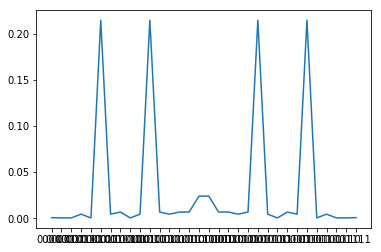

In [28]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
import pyquil.api as api
qvm_connection = api.QVMConnection()

wiki = [(0,1),(0,2),(0,3),(0,4),[0,5],[5,4]]
wiki = [(0,1),(1,2),(2,3),(3,0),[0,4],[1,4],[2,4],[3,4]]

steps = 4
inst = maxcut_qaoa(graph=wiki, steps=steps)
betas, gammas = inst.get_angles()

t = np.hstack((betas, gammas))
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = qvm_connection.wavefunction(prog)
wf = wf.amplitudes

for state_index in range(inst.nstates):
    print(inst.states[state_index], abs(np.conj(wf[state_index])*wf[state_index]))
    
import matplotlib.pyplot as plt
import cmath 
plt.plot(inst.states, abs(np.conj(wf)*wf))

The set with the minimum number of 0 or 1, is the vertex cover (among the solution strings of Max-Cut)